In [1]:
import time
import os

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd

In [2]:
JetHT2016_unweighted = util.load('TTbarResCoffea_JetHT2016_Data_unweighted_output.coffea')
JetHT2016_weighted = util.load('TTbarResCoffea_JetHT2016_Data_weighted_output.coffea')

JetHT2017_unweighted = util.load('TTbarResCoffea_JetHT2017_Data_unweighted_output.coffea')
JetHT2017_weighted = util.load('TTbarResCoffea_JetHT2017_Data_weighted_output.coffea')

JetHT2018_unweighted = util.load('TTbarResCoffea_JetHT2018_Data_unweighted_output.coffea')
JetHT2018_weighted = util.load('TTbarResCoffea_JetHT2018_Data_weighted_output.coffea')

In [3]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [4]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [5]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

# ---- List the Histograms Here ---- #
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep')

In [6]:
maindirectory = os.getcwd() 

In [7]:
stack_ttbar_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'red'}
stack_background_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'yellow'}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'None', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

In [8]:
""" ---------------- Luminosity and Cross Sections ---------------- """
Lum = 41530. # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable

TTbar_BR = 0.457 # 0.442 from PDG 2018
ttbar_xs = 831.76 * TTbar_BR  #pb
qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb

In [9]:
# ---- Optional to rescale x-axis of mistag rates ---- #
def forward(x):
    return x**(1/2)

def inverse(x):
    return x**2

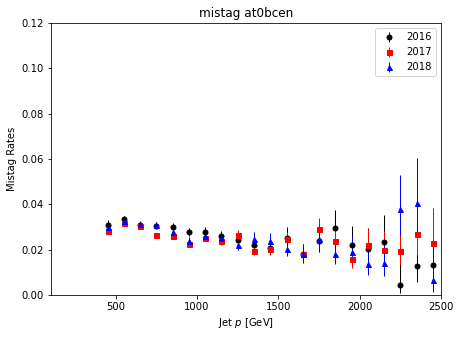

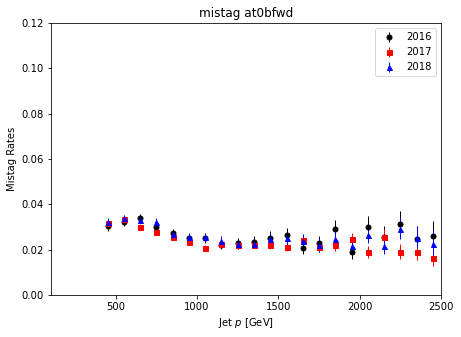

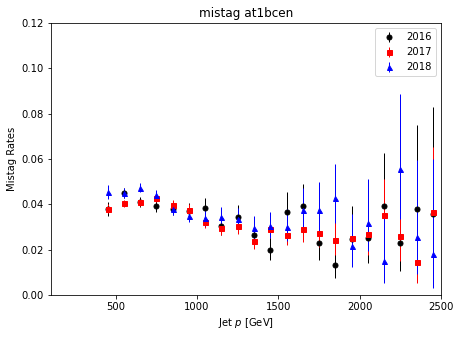

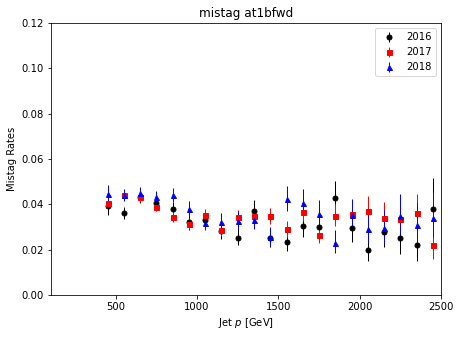

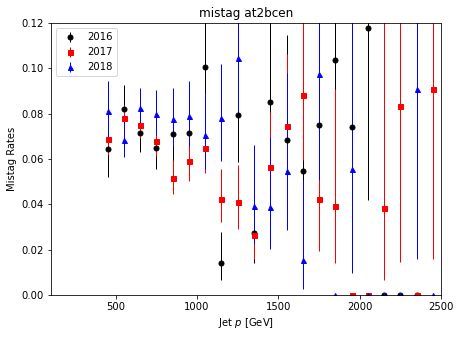

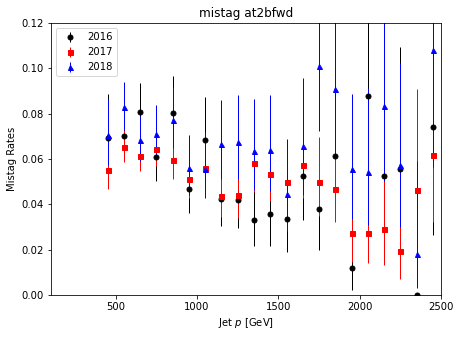

In [12]:
for icat in list_of_cats:
    if 'at' in icat:
        fig, ax = plt.subplots(
            #nrows=2,
            #ncols=1,
            figsize=(7,5),
            #gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        title = 'mistag ' + icat
        
        Numerator2016 = JetHT2016_unweighted['numerator'].integrate('anacat', icat).integrate('dataset', 'JetHT')
        Denominator2016 = JetHT2016_unweighted['denominator'].integrate('anacat', icat).integrate('dataset', 'JetHT')
        
        Numerator2017 = JetHT2017_unweighted['numerator'].integrate('anacat', icat).integrate('dataset', 'JetHT')
        Denominator2017 = JetHT2017_unweighted['denominator'].integrate('anacat', icat).integrate('dataset', 'JetHT')
        
        Numerator2018 = JetHT2018_unweighted['numerator'].integrate('anacat', icat).integrate('dataset', 'JetHT')
        Denominator2018 = JetHT2018_unweighted['denominator'].integrate('anacat', icat).integrate('dataset', 'JetHT')
       
        mistag2016 = hist.plotratio(num = Numerator2016, denom = Denominator2016, ax=ax, clear=False,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        mistag2017 = hist.plotratio(num = Numerator2017, denom = Denominator2017, ax=ax, clear=False,
                                error_opts={'marker': 's', 'markersize': 5., 'color': 'r', 'elinewidth': 1},
                                unc = 'num')
        mistag2018 = hist.plotratio(num = Numerator2018, denom = Denominator2018, ax=ax, clear=False,
                                error_opts={'marker': '^', 'markersize': 5., 'color': 'b', 'elinewidth': 1},
                                unc = 'num')
        
        plt.ylim(bottom = 0, top = 0.12)
        plt.xlim(left = 100, right = 2500)
       
        ax.set_ylabel('Mistag Rates')
        ax.set_title(title)
        leg = ax.legend(labels=["2016", "2017", "2018"])
        
        # ---- Optional x-axis scaling ---- #
        #plt.xticks(np.array([0, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]))
        #plt.xlim(left = 100, right = 10000)
        #mistag.set_xscale('function', functions=(forward, inverse))
        #mistag.set_xscale('log')
    else:
        continue

([<matplotlib.axis.XTick at 0x7f88f4bb20d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

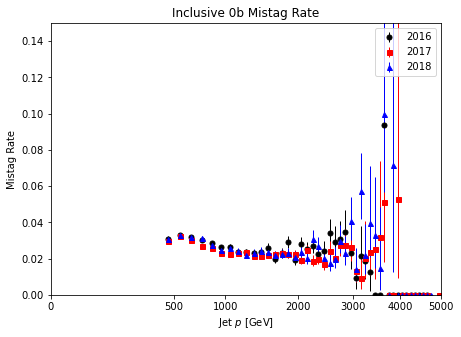

In [16]:
""" ---------- Rapidity Inclusive Mistag Rates ---------- """

btag = '0b'

fig, ax = plt.subplots(
    #nrows=2,
    #ncols=1,
    figsize=(7,5),
    #gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
title = 'Inclusive ' + btag + ' Mistag Rate'

Num_cen2016 = JetHT2016_unweighted['numerator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT')
Denom_cen2016 = JetHT2016_unweighted['denominator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT')

Num_fwd2016 = JetHT2016_unweighted['numerator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT')
Denom_fwd2016 = JetHT2016_unweighted['denominator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT')

Num_inc2016 = Num_cen2016.add(Num_fwd2016)
Denom_inc2016 = Denom_cen2016.add(Denom_fwd2016)
mistag_inclusive2016 = hist.plotratio(num = Num_inc2016, denom = Denom_inc2016, ax=ax, clear=False,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')



Num_cen2017 = JetHT2017_unweighted['numerator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT')
Denom_cen2017 = JetHT2017_unweighted['denominator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT')

Num_fwd2017 = JetHT2017_unweighted['numerator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT')
Denom_fwd2017 = JetHT2017_unweighted['denominator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT')

Num_inc2017 = Num_cen2017.add(Num_fwd2017)
Denom_inc2017 = Denom_cen2017.add(Denom_fwd2017)
mistag_inclusive2017 = hist.plotratio(num = Num_inc2017, denom = Denom_inc2017, ax=ax, clear=False,
                                error_opts={'marker': 's', 'markersize': 5., 'color': 'r', 'elinewidth': 1},
                                unc = 'num')



Num_cen2018 = JetHT2018_unweighted['numerator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT')
Denom_cen2018 = JetHT2018_unweighted['denominator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT')

Num_fwd2018 = JetHT2018_unweighted['numerator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT')
Denom_fwd2018 = JetHT2018_unweighted['denominator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT')

Num_inc2018 = Num_cen2018.add(Num_fwd2018)
Denom_inc2018 = Denom_cen2018.add(Denom_fwd2018)
mistag_inclusive2018 = hist.plotratio(num = Num_inc2018, denom = Denom_inc2018, ax=ax, clear=False,
                                error_opts={'marker': '^', 'markersize': 5., 'color': 'b', 'elinewidth': 1},
                                unc = 'num')
plt.ylim(bottom = 0, top = 0.15)
plt.xlim(left = 100, right = 5000)

ax.set_ylabel('Mistag Rates')
ax.set_title(title)
leg = ax.legend(labels=["2016", "2017", "2018"])

# ---- Optional x-axis scaling ---- #
ax.set_xscale('function', functions=(forward, inverse))
plt.xticks(np.array([0, 500, 1000, 2000, 3000, 4000, 5000]))
#ax.set_xscale('log')

Mean Mistag Rate (MMR) =  0.006325808369479944
Number of Data =        110416
Number of Background =  110416

                p      M(p)  unwgt at0bcen MC  wgt at0bcen MC  At0bcen MC
0        [0, 100)  0.000000               0.0             0.0         0.0
1      [100, 200)  0.000000               0.0             0.0         0.0
2      [200, 300)  0.000000               0.0             0.0         0.0
3      [300, 400)  0.000000               0.0             0.0         0.0
4      [400, 500)  0.030144            8747.0           271.0       271.0
5      [500, 600)  0.032433           19927.0           669.0       669.0
6      [600, 700)  0.031448           20900.0           642.0       642.0
7      [700, 800)  0.030990           15626.0           477.0       477.0
8      [800, 900)  0.027794           11562.0           346.0       346.0
9     [900, 1000)  0.023863            8059.0           223.0       223.0
10   [1000, 1100)  0.025753            6055.0           167.0       167.0
11

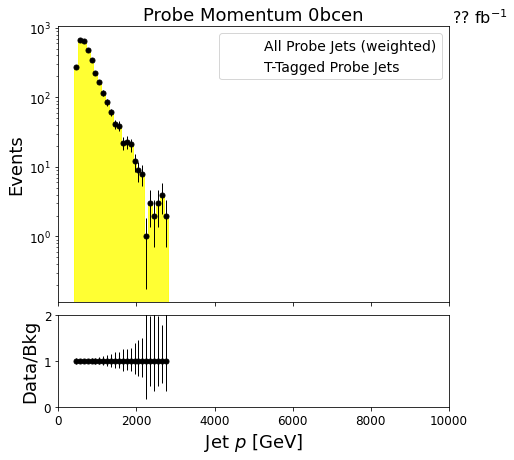

In [17]:
""" ---------- Comparing Background Estimate to Unweighted MC (TEST WITHOUT DATA/ CLOSURE TEST) ---------- """
SaveDirectory = maindirectory + '/' + 'ClosureTests' + '/' # split histograms into subdirectories
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already

#---- Histogram Window Config. ----# 
plt.rcParams.update({
'font.size': 14,
'axes.titlesize': 18,
'axes.labelsize': 18,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)
b_y = '0bcen' # b-tag category and rapidity window

#---- Useful Information ----# 
lut_file = maindirectory + '/LookupTables/mistag_JetHT_at' + b_y + '.csv'
df = pd.read_csv(lut_file)
p_vals = df['p']
mtr = df['M(p)'].values
MMR = mtr.sum()/mtr.size
print('Mean Mistag Rate (MMR) = ', MMR)
#print(p_vals)
#print(mtr)

nevts = JetHT2016_unweighted['cutflow']['at'+b_y]
bkg_nevts = JetHT2016_weighted['cutflow']['at'+b_y]

print('Number of Data =       ', nevts)
print('Number of Background = ', bkg_nevts)
print()

#---- Define Histograms ----# 
hist_wgt_anacat = 'at' + b_y
hist_unwgt_anacat = 'At' + b_y
hist_unwgt_pretag_anacat = 'at' + b_y

MC_hist_wgt = JetHT2016_weighted['probep'].integrate('anacat', hist_wgt_anacat).integrate('dataset', 'JetHT')
MC_hist_unwgt = JetHT2016_unweighted['probep'].integrate('anacat', hist_unwgt_anacat).integrate('dataset', 'JetHT')
MC_hist_unwgt_pretag = JetHT2016_unweighted['probep'].integrate('anacat', hist_unwgt_pretag_anacat).integrate('dataset', 'JetHT')

hist.plot1d(MC_hist_wgt, ax=ax, clear=True,
                    fill_opts=stack_background_opts, error_opts=stack_error_opts)
hist.plot1d(MC_hist_unwgt, ax=ax, clear=False,
                    error_opts=data_err_opts)

d = {'p': p_vals, 'M(p)': mtr, 
     'unwgt at0bcen MC': MC_hist_unwgt_pretag.values()[()], 
     'wgt at0bcen MC': MC_hist_wgt.values()[()], 
     'At0bcen MC': MC_hist_unwgt.values()[()]}
df1 = pd.DataFrame(data=d)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(df1)

ax.set_yscale('log')
ax.autoscale('y')
ax.autoscale('x')#, tight=True) # doesn't look like its working...
ax.set_ylabel('Events')
ax.set_xlabel(None)
ax.set_title('Probe Momentum ' + b_y)
leg = ax.legend(labels=["All Probe Jets (weighted)", "T-Tagged Probe Jets"])

#---- Plot Ratio ----#
hist.plotratio(num = MC_hist_unwgt, denom = MC_hist_wgt, ax = rax,
               error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
               unc = 'num')
rax.set_ylabel('Data/Bkg')
rax.set_ylim(0,2)

#---- Labeling ----#
lumi = plt.text(1.15, 1.07, "?? fb$^{-1}$",
        fontsize=16,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )

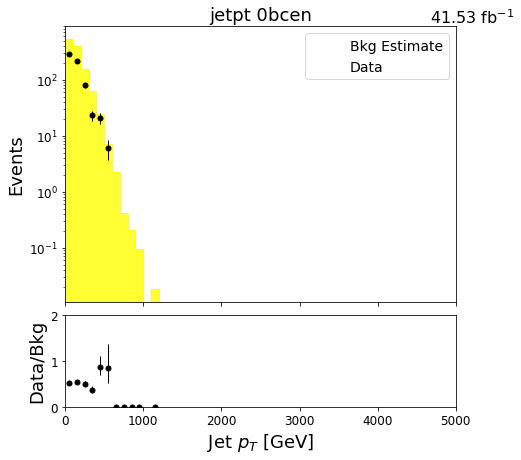

In [18]:
""" ---------- Comparing Background Estimate to Unweighted Data (Checks One Histogram) ---------- """
""" --------------- Background: t tagged probe jet from data weighted by mistag --------------- """
""" --------------- Data: Unweighted Data from the Signal Region (2t tag region) -------------- """
 
plt.rcParams.update({
'font.size': 14,
'axes.titlesize': 18,
'axes.labelsize': 18,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

#---- Name of Histogram to plot ----#
name = 'jetpt'

#---- Define Histograms ----# 
Data_hist_wgt_1 = JetHT2016_weighted[name].integrate('anacat', '1t0bcen').integrate('dataset', 'JetHT')
Data_hist_wgt_2 = JetHT2016_weighted[name].integrate('anacat', '2t0bcen').integrate('dataset', 'JetHT')
Data_hist_unwgt = JetHT2016_unweighted[name].integrate('anacat', '2t0bcen').integrate('dataset', 'JetHT')
Data_hist_preunwgt = JetHT2016_unweighted[name].integrate('anacat', '1t0bcen').integrate('dataset', 'JetHT')

#print("Only 1t weighted region = \n", Data_hist_wgt_1.values())
#print("Only 1t pre-weighted region = \n", Data_hist_preunwgt.values())
#print("2t weighted region = \n", Data_hist_wgt_2.values())
#print("2t unweighted region (Signal) = \n", Data_hist_unwgt.values())

Background = Data_hist_wgt_1.add(Data_hist_wgt_2)
Signal = Data_hist_unwgt

hist.plot1d(Background, ax=ax, clear=True,
                    fill_opts=stack_background_opts, error_opts=stack_error_opts)
hist.plot1d(Signal, ax=ax, clear=False,
                    error_opts=data_err_opts)

ax.set_yscale('log')
ax.autoscale('y')
ax.autoscale('x')#, tight=True) # doesn't look like its working...
ax.set_ylabel('Events')
ax.set_xlabel(None)
ax.set_title(name + ' 0bcen')
leg = ax.legend(labels=["Bkg Estimate", "Data"])

#---- Plot Ratio ----#
hist.plotratio(num = Signal, denom = Background, ax = rax,
               error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
               unc = 'num')
rax.set_ylabel('Data/Bkg')
rax.set_ylim(0,2)

#---- Labeling ----#
Lint = str(Lum*.001) # Integrated Luminosity
lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
        fontsize=16,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )